네이버 쇼핑 데이터
   - https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import warnings
warnings.filterwarnings('ignore')

데이터 로드

In [4]:
import urllib.request

urllib.request.urlretrieve('https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt', filename='shopping.txt')

('shopping.txt', <http.client.HTTPMessage at 0x17324a6f648>)

In [5]:
total_data = pd.read_table('shopping.txt', names=['ratings', 'reviews'])
print(len(total_data))

200000


훈련 데이터와 테스트 데이터 분리

In [6]:
# 평점이 4점 이상일 경우에는 1, 아니면 0을 주는 column인 'label' 생성
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)

In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
# 중복 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print(len(total_data))

199908


In [9]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=111)

레이블 분포 확인

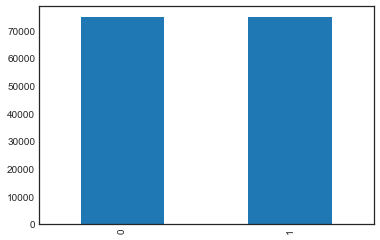

In [10]:
train_data['label'].value_counts().plot(kind='bar');

In [11]:
train_data.groupby('label').size().reset_index(name='count')

,label,count
0,0,74974
1,1,74957


데이터 정제

In [12]:
# 정규화
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "")
train_data['reviews'].replace("", np.nan, inplace=True)
print(len(train_data))

test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣 ]", "")
test_data['reviews'].replace("", np.nan, inplace=True)
print(len(test_data))

149931
49977


토큰화 및 불용어 제거
   - 불용어 사전 : '도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게'

In [13]:
stopwords = [ '도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게']

In [14]:
# 불용어 제거 및 형태소분섯
mecab = Mecab("C:/mecab/mecab-ko-dic")

train_data['reviews'] = train_data['reviews'].apply(mecab.morphs)
train_data['reviews'] = train_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['reviews'] = test_data['reviews'].apply(mecab.morphs)
test_data['reviews'] = test_data['reviews'].apply(lambda x: [item for item in x if item not in stopwords])

In [15]:
# x와 y 나누기
x_train = train_data['reviews'].values
y_train = train_data['label'].values
x_test = test_data['reviews'].values
y_test = test_data['label'].values

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(149931,) (149931,) (49977,) (49977,)


빈도 수가 낮은 단어 제거

In [16]:
# x_train 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

In [17]:
threshold = 3
word_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0 
rare_freq = 0

for key, value in tokenizer.word_counts.items():
    word_freq = words_freq + value
    
    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value
print("전체 단어 수 : ", word_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format((rare_cnt / word_cnt)*100))
# print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq / words_freq)*100))

전체 단어 수 :  40060
빈도가 2 이하인 희귀 단어 수 : 23111
희귀 단어 비율 : 57.690963554667995


In [18]:
vocab_size = word_cnt - rare_cnt + 2
print(vocab_size)

16951


In [19]:
# 토큰화된 단어들을 숫자로 변형
tokenizer = Tokenizer(vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

패딩
   - 단어의 길이를 맞춰줌

In [20]:
print("리뷰 최대 길이 : ", max(len(l) for l in x_train))
print("리뷰 평균 길이 : ", sum(map(len, x_train))/len(x_train))

리뷰 최대 길이 :  85
리뷰 평균 길이 :  15.329031354423035


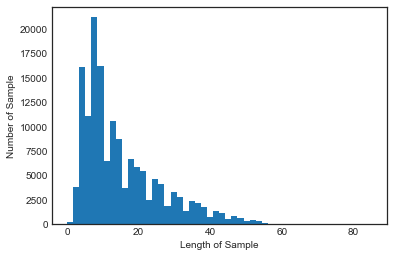

In [21]:
# 시각화
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel("Length of Sample")
plt.ylabel("Number of Sample")
plt.show()

In [22]:
max_len = 60

x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

모델 생성 및 훈련

In [23]:
model = Sequential()

model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
hist = model.fit(x_train, y_train, epochs=15, callbacks=[es], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - 21s 10ms/step - loss: 0.2719 - acc: 0.8970 - val_loss: 0.2294 - val_acc: 0.9157
Epoch 2/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.2131 - acc: 0.9238 - val_loss: 0.2207 - val_acc: 0.9207
Epoch 3/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1978 - acc: 0.9299 - val_loss: 0.2114 - val_acc: 0.9243
Epoch 4/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1883 - acc: 0.9336 - val_loss: 0.2130 - val_acc: 0.9240
Epoch 5/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1800 - acc: 0.9370 - val_loss: 0.2173 - val_acc: 0.9217
Epoch 6/15
1875/1875 [==============================] - 18s 9ms/step - loss: 0.1718 - acc: 0.9401 - val_loss: 0.2216 - val_acc: 0.9227
Epoch 7/15
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1638 - acc: 0.9434 - val_loss: 0.2162 - val_acc: 0.9216
Epoch 8/15
1875/1875 [==============================]

In [25]:
model.evaluate(x_test, y_test)

1562/1562 [==============================] - 6s 4ms/step - loss: 0.2246 - acc: 0.9250


[0.2246340960264206, 0.924965500831604]

시각화

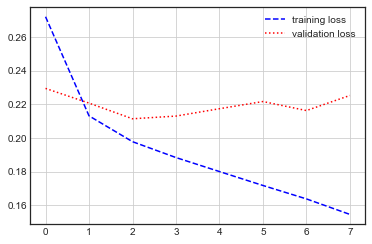

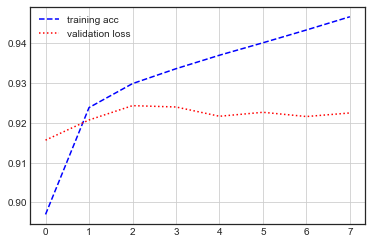

In [26]:
hist_dict = hist.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label="training loss")
plt.plot(val_loss, 'r:', label="validation loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label="training acc")
plt.plot(val_acc, 'r:', label="validation loss")
plt.legend()
plt.grid()

감정 예측

In [27]:
def sentiment_predict(new_sentence):
    new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
    new_sequences = tokenizer.texts_to_sequences([new_token])
    new_pad = pad_sequences(new_sequences, maxlen=max_len)
    score = float(model.predict(new_pad))
    
    if score > 0.5:
        print("{} -> 긍정({:.2f})%".format(new_sentence, score*100))
    else:
        print("{} -> 부정({:.2f})%".format(new_sentence, (1-score)*100))

In [28]:
sentiment_predict('처음 써봤는데 대박 좋아요.')
sentiment_predict('원래 배송이 이렇게 늦나요?')
sentiment_predict('추가 구매 의향이 있습니다. 대박!')
sentiment_predict('이거 정말 리뷰쓰는것조차 아깝네...')

처음 써봤는데 대박 좋아요. -> 긍정(97.71)%
원래 배송이 이렇게 늦나요? -> 부정(96.01)%
추가 구매 의향이 있습니다. 대박! -> 긍정(89.56)%
이거 정말 리뷰쓰는것조차 아깝네... -> 부정(91.13)%
